In [1]:
#Python Implementation of the Hartree Fock Method
#Procedures listed in the code follow as described in Modern Quantum Chemistry: Introduction to Advanced Electronic Structure Theory, By Attila Szabo and Neil S. Ostlundimport math
import numpy as np
from molecule import atom
from molecule import vector
from molecule import guassian
from molecule import molecule
from notebookImporter import importNotebook

#import integrals notebook for the hartree method
integrals = importNotebook("hartree_integrals")
scf = importNotebook("hartree_scf")

#define SCF convergence critera
SCF_CONVERGENCE = pow(10, -50)

#Step 1
#Specify Molecules, Nuclear Coordinates, and Charge of the nucli Number of Electrons,

#generate an h2 atom with a distance of 1.4 AU to compare with Szabo pg. 175
R = 1.4
h2 = molecule()
h2.addAtom(atom(vector(9,9,9+R), 1, 1))
h2.addAtom(atom(vector(9,9,9), 1, 1))
#h2.addAtom(atom(vector(9,9,11),1,1))
h2.addBasis("STO-3G")
#and a basis set, for now will add default basis of STO-3G for hydrogen to all atoms
h2.display()

Molecule
Basis Set: STO-3G
Total Number of Electrons: 2
Atoms: 
     Atomic Number: 1, Electrons: 1, Coordinate: X: 9 Y: 9 Z: 10.4
     Atomic Number: 1, Electrons: 1, Coordinate: X: 9 Y: 9 Z: 9


Overlap Matrix: 
[[0.99999999 0.6593182 ]
 [0.6593182  0.99999999]]

Electron Kinetic Energy Operator: 
[[0.76003188 0.23645465]
 [0.23645465 0.76003188]]

Electronic Hamiltonian :
[[-1.120409   -0.95837996]
 [-0.95837996 -1.120409  ]]



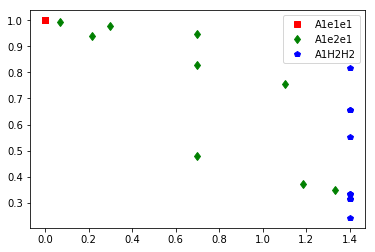

In [2]:
#Step 2
#Calculate Integrals
#Overlap, KE, Nuclear Attraaction, and electron repulsion
S = integrals.overlap(h2)
print("Overlap Matrix: ")
print(np.matrix(S))
print()

T = integrals.kineticEnergy(h2)
print("Electron Kinetic Energy Operator: ")
print(np.matrix(T))
print()

V = integrals.nuclearAttraction(h2)

electronRepulsion = integrals.electronElectronRepulsion(h2)

#convert lists into numpy matrices in order to more easily form the electronic hamiltonian
H = np.matrix(T)

#add in all of the nuclear attractions matricies to the hamiltonian
for atom in V:
    H += np.matrix(atom)
        
print("Electronic Hamiltonian :")
print(H)
print()

#print(electronRepulsion[0][0][0][0])
#print(electronRepulsion[0][0][1][1])
#print(electronRepulsion[1][0][1][1])
#print(electronRepulsion[1][0][1][0])

In [3]:
#Prepare for the SCF procedure

#get size of the basis set 
size = len(S)

#compute the Transformation Matrix
X = scf.X(S, size)

#get guess Fock matrix
F = H

In [12]:
# SCF Procedure 

#init list to store the energy from each iteration
#as well as a boolean to store whether or not the energy has converged
E = []
converged = False

while( not converged ):
  
    #diagnolze the Fock matrix and convert it to MO basis 
    F = X.transpose() * F * X 
        
   #diagnolize the Fock Matrix to obtain the MOs and the their respective energies
    MOEnergy, MO = np.linalg.eig(F)

    #Transform the MO basis MOs to an AO basis
    C = X * MO
    
    #compute the electron density, the two electron term, and then use G to compute the new Fock matrix
    P = scf.densityMatrix(C, h2.N, size)
    G = scf.G(electronRepulsion, P, size)
    F = H + G
    
    #compute the new expectation energy 
    E.append(scf.expectationEnergy(H, F, P))
    
    #display information about current SCF iteration to the user
    sizeE = len(E)
    print("SCF Iteration #" + str(sizeE) + ", Energy Value: " + str(E[sizeE-1]) + " Hartrees")
    
    #check if at least two SCF iterations have occured
    #if more than two have occured, then check if the difference betweeen this E, 
    #and the previous E is less then the covergence value, if yes, end the SCF loop
    if(len(E) > 2):
        if(abs(E[sizeE-2] - E[sizeE-1]) < SCF_CONVERGENCE):
            converged = True
            
#add in nuclear-nuclear repulsion to the energy
nuclearRepulsion = 0 
for atom1 in h2.atomData:
    for atom2 in h2.atomData:
        
        if(atom1 == atom2):
            continue
        
        nuclearRepulsion = (atom1.Z * atom2.Z) / (atom1.coord - atom2.coord).magnitude()
        
totalE = E[sizeE-1] + nuclearRepulsion
print(totalE)        

#write to file with all energies and bond distances of H2            
energyFile = open('Energy.txt', 'a')
energyFile.write("R:" + str(R) + "    " + "E:" + str(E[sizeE-1]) + "\n")
energyFile.close()

SCF Iteration #1, Energy Value: -1.8310000393482846 Hartrees
SCF Iteration #2, Energy Value: -1.8310000393482846 Hartrees
SCF Iteration #3, Energy Value: -1.8310000393482846 Hartrees
-1.1167143250625706


[0.1, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.4, 2.4, 1.4, 1.4, 1.4, 1.4, 1.4]
[-2.601471591076995, -2.403326441654481, -2.2657017267923325, -2.197307931116021, -2.130608167085682, -2.0659994621433038, -2.003655007248249, -1.9436672160135087, -1.8861019096815994, -1.8310000393482846, -1.7783625600353312, -1.68024114314351, -1.6345377674724813, -1.5908926676021355, -1.5491709019858155, -1.5092513332182258, -1.4710311760624826, -1.4344258366039377, -1.3993659929751918, -1.3993659929751918, -1.3993659929751918, -1.8310000393482846, -1.8310000393482846, -1.8310000393482846, -1.8310000393482846, -1.8310000393482846]


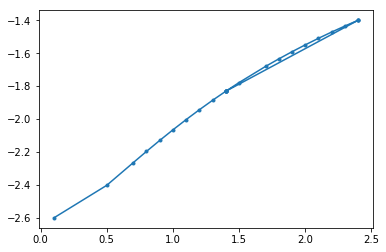

In [10]:
from matplotlib import pyplot as plt

energyFile = open('Energy.txt', 'r')

distance = []
energy = []

for line in energyFile:
    lineData = line.split("\n")[0].split("    ")
    
    distance.append(float(lineData[0].split(":")[1]))
    energy.append(float(lineData[1].split(":")[1]))
    
print(distance)
print(energy)
energyFile.close()    

plt.plot(distance, energy,'.-')
plt.show()